## Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

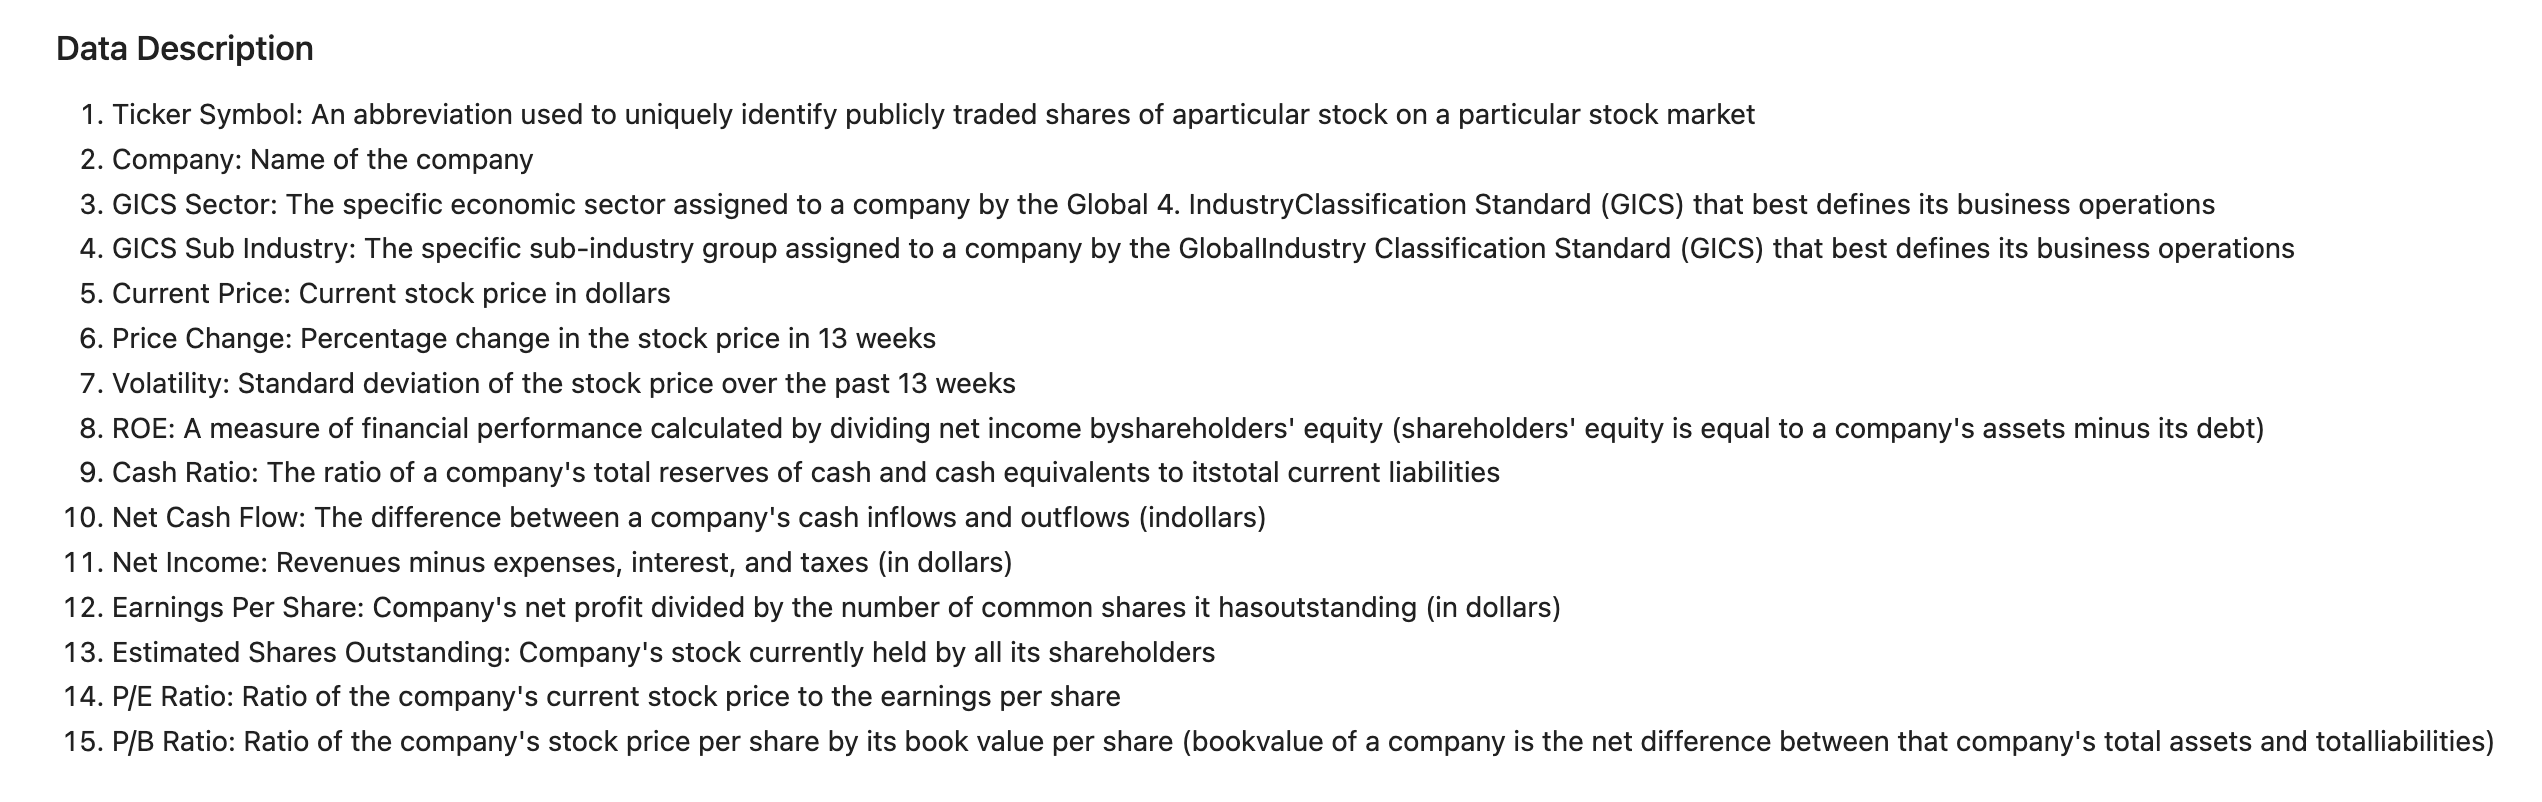

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist
# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from scipy.stats import zscore
from sklearn.decomposition import PCA

## Data Observation

In [2]:
# loading the dataset
data = pd.read_csv("stock_data.csv")

In [3]:
data.shape

(340, 15)

In [4]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.224320,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.029999,7.578608,1.163334,15,47,21818000,248710000,1.52,1.636250e+08,26.335526,-1.269332
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.410004,10.660538,0.806056,17,129,160383000,636056000,3.28,4.913916e+08,24.070121,-2.256747
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.610001,0.865287,1.589520,32,64,-588000000,-7829000000,-10.23,7.652981e+08,93.089287,3.345102
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,4.353535e+08,17.682214,-3.838260
112,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production,52.130001,-21.253771,2.364883,2,201,523803000,85171000,0.56,1.520911e+08,93.089287,9.567952
147,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services,34.040001,-5.101751,1.966062,4,189,7786000000,-671000000,-0.79,8.493671e+08,93.089287,17.345857
89,DFS,Discover Financial Services,Financials,Consumer Finance,53.619999,3.653584,1.159897,20,99,2288000000,2297000000,5.14,4.468872e+08,10.431906,-0.375934
173,IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks,33.480000,7.067477,1.580839,12,67,412000000,968100000,2.26,4.283628e+08,14.814159,4.218620


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [6]:
# creating a copy of data
df=data.copy()

In [7]:
# fixing column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [8]:
df.columns

Index(['Ticker_Symbol', 'Security', 'GICS_Sector', 'GICS_Sub_Industry',
       'Current_Price', 'Price_Change', 'Volatility', 'ROE', 'Cash_Ratio',
       'Net_Cash_Flow', 'Net_Income', 'Earnings_Per_Share',
       'Estimated_Shares_Outstanding', 'P/E_Ratio', 'P/B_Ratio'],
      dtype='object')

In [9]:
# We don't need "Ticker_symbol" for this analysis. Let us drop that
df.drop("Ticker_Symbol", axis=1, inplace=True)

In [10]:
# Let's look at the statistical summary of the data
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Security,340,340,American Airlines Group,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GICS_Sector,340,11,Industrials,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GICS_Sub_Industry,340,104,Oil & Gas Exploration & Production,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Current_Price,340.0,NaN,NaN,NaN,80.862345,98.055086,4.5,38.555,59.705,92.880001,1274.949951
Price_Change,340.0,NaN,NaN,NaN,4.078194,12.006338,-47.129693,-0.939484,4.819505,10.695493,55.051683
Volatility,340.0,NaN,NaN,NaN,1.525976,0.591798,0.733163,1.134878,1.385593,1.695549,4.580042
ROE,340.0,NaN,NaN,NaN,39.597059,96.547538,1.0,9.75,15.0,27.0,917.0
Cash_Ratio,340.0,NaN,NaN,NaN,70.023529,90.421331,0.0,18.0,47.0,99.0,958.0
Net_Cash_Flow,340.0,NaN,NaN,NaN,55537620.588235,1946365312.175789,-11208000000.0,-193906500.0,2098000.0,169810750.0,20764000000.0
Net_Income,340.0,NaN,NaN,NaN,1494384602.941176,3940150279.327937,-23528000000.0,352301250.0,707336000.0,1899000000.0,24442000000.0


## Exploratory Data Analysis (EDA)

In [11]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [12]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

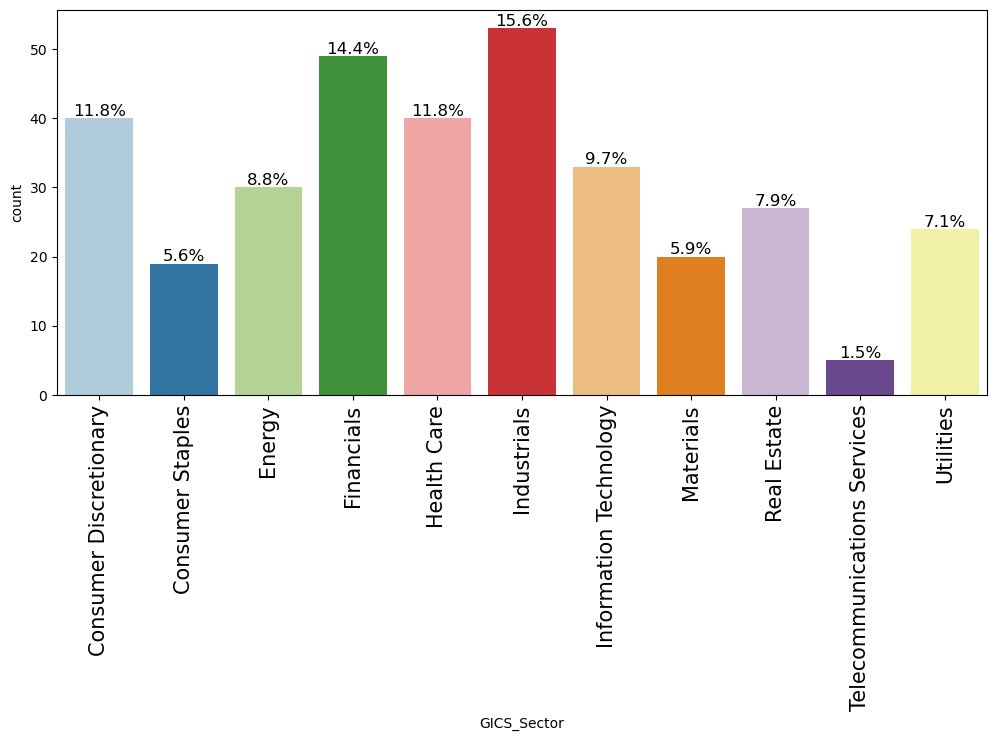

In [13]:
labeled_barplot(df, "GICS_Sector", perc=True)

### 30% of data is from Financials and Industrials sectors. Less than 2% data is from Telecom services sector

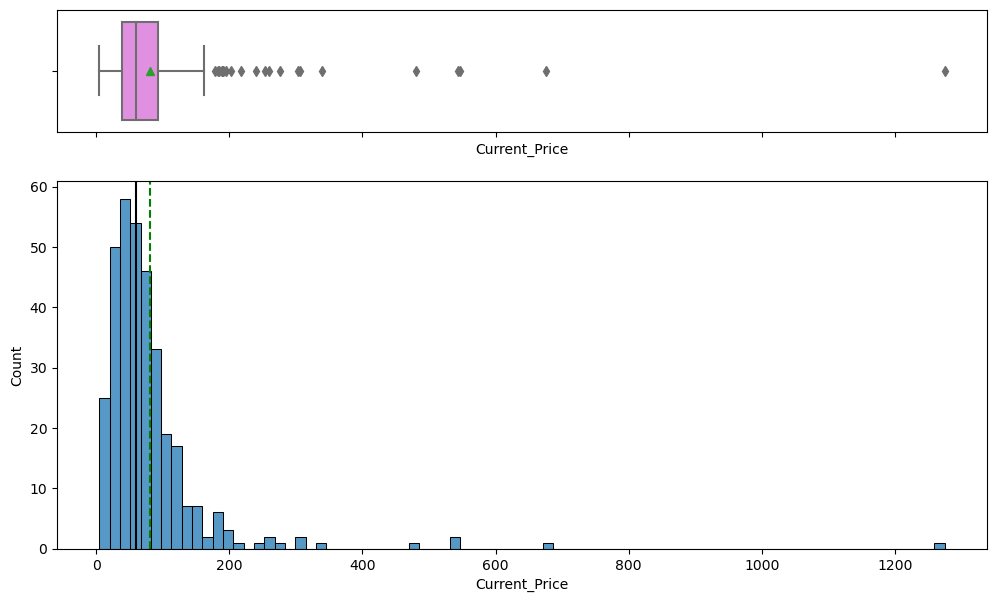

In [14]:
histogram_boxplot(df,"Current_Price")

### The distribution of stock price is right skewed, with a number of ouliers towards the high end

Questions you may have:

    1.The stocks of which economic sector have seen the maximum price increase on average?
    2.Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents.How does the average cash ratio vary across economic sectors?
    3.P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?
    4.How are the different variables correlated with each other?

In [15]:
df.groupby(["GICS_Sector"])["Price_Change"].mean().sort_values(ascending=False)

GICS_Sector
Health Care                     9.585652
Consumer Staples                8.684750
Information Technology          7.217476
Telecommunications Services     6.956980
Real Estate                     6.205548
Consumer Discretionary          5.846093
Materials                       5.589738
Financials                      3.865406
Industrials                     2.833127
Utilities                       0.803657
Energy                        -10.228289
Name: Price_Change, dtype: float64

### The Health Care sector stocks have seen the maximum price increase, on an average

<AxesSubplot:ylabel='GICS_Sector'>

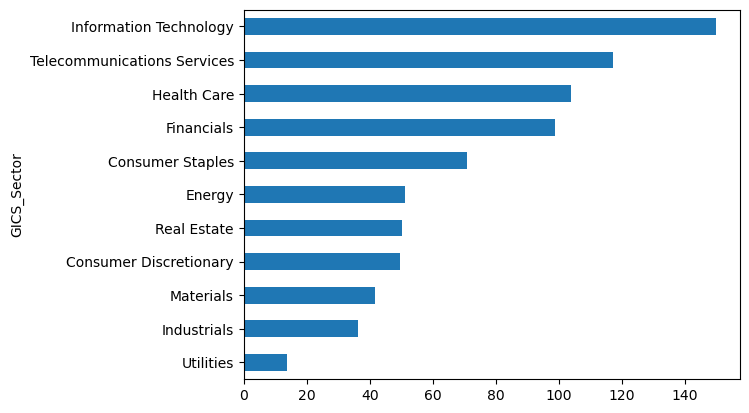

In [16]:
df.groupby('GICS_Sector').Cash_Ratio.mean().sort_values(ascending=True).plot.barh()

### IT sector has the maximum cash ratio, followed by telecom services. Utilities sector has the minimum cash ratio. The average cash ratio for all companies is 70

<AxesSubplot:ylabel='GICS_Sector'>

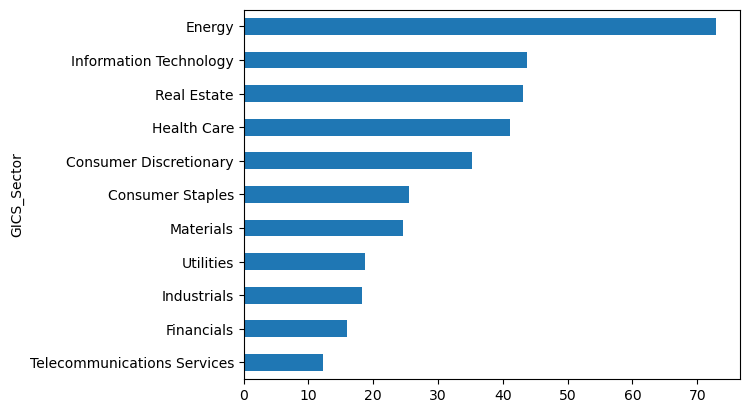

In [17]:
df.groupby(['GICS_Sector'])["P/E_Ratio"].mean().sort_values(ascending=True).plot.barh()

### Energy sector has the maximum P/E ratio, Telecom services have the least P/E ratio. The avearge P/E for all companies is 32.2

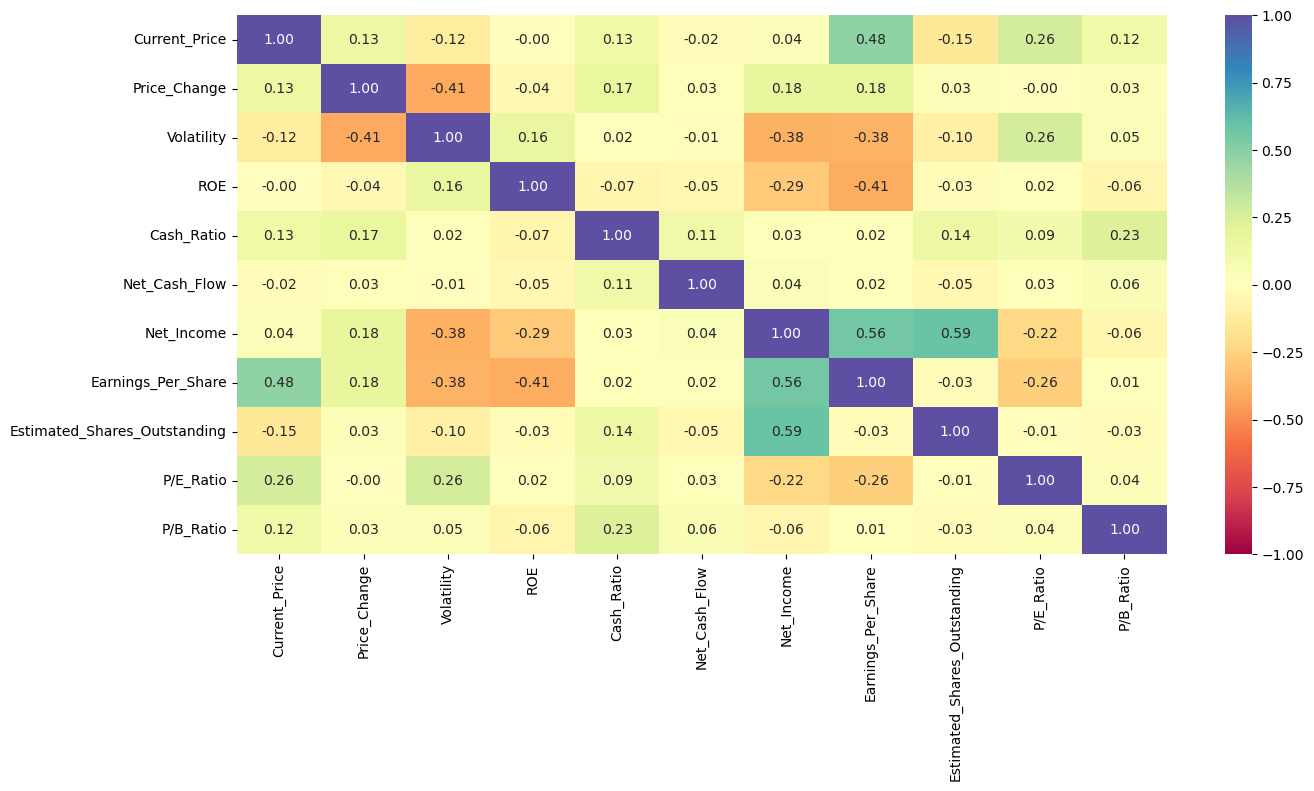

In [18]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 7))
sns.heatmap(
    df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### Correlations among numeric variables are generally low. The noticeable correlations are: Positive correlation between net income and EPS and no. of shares outstanding. Also a positive correlation between EPS and current price, which is interesting.

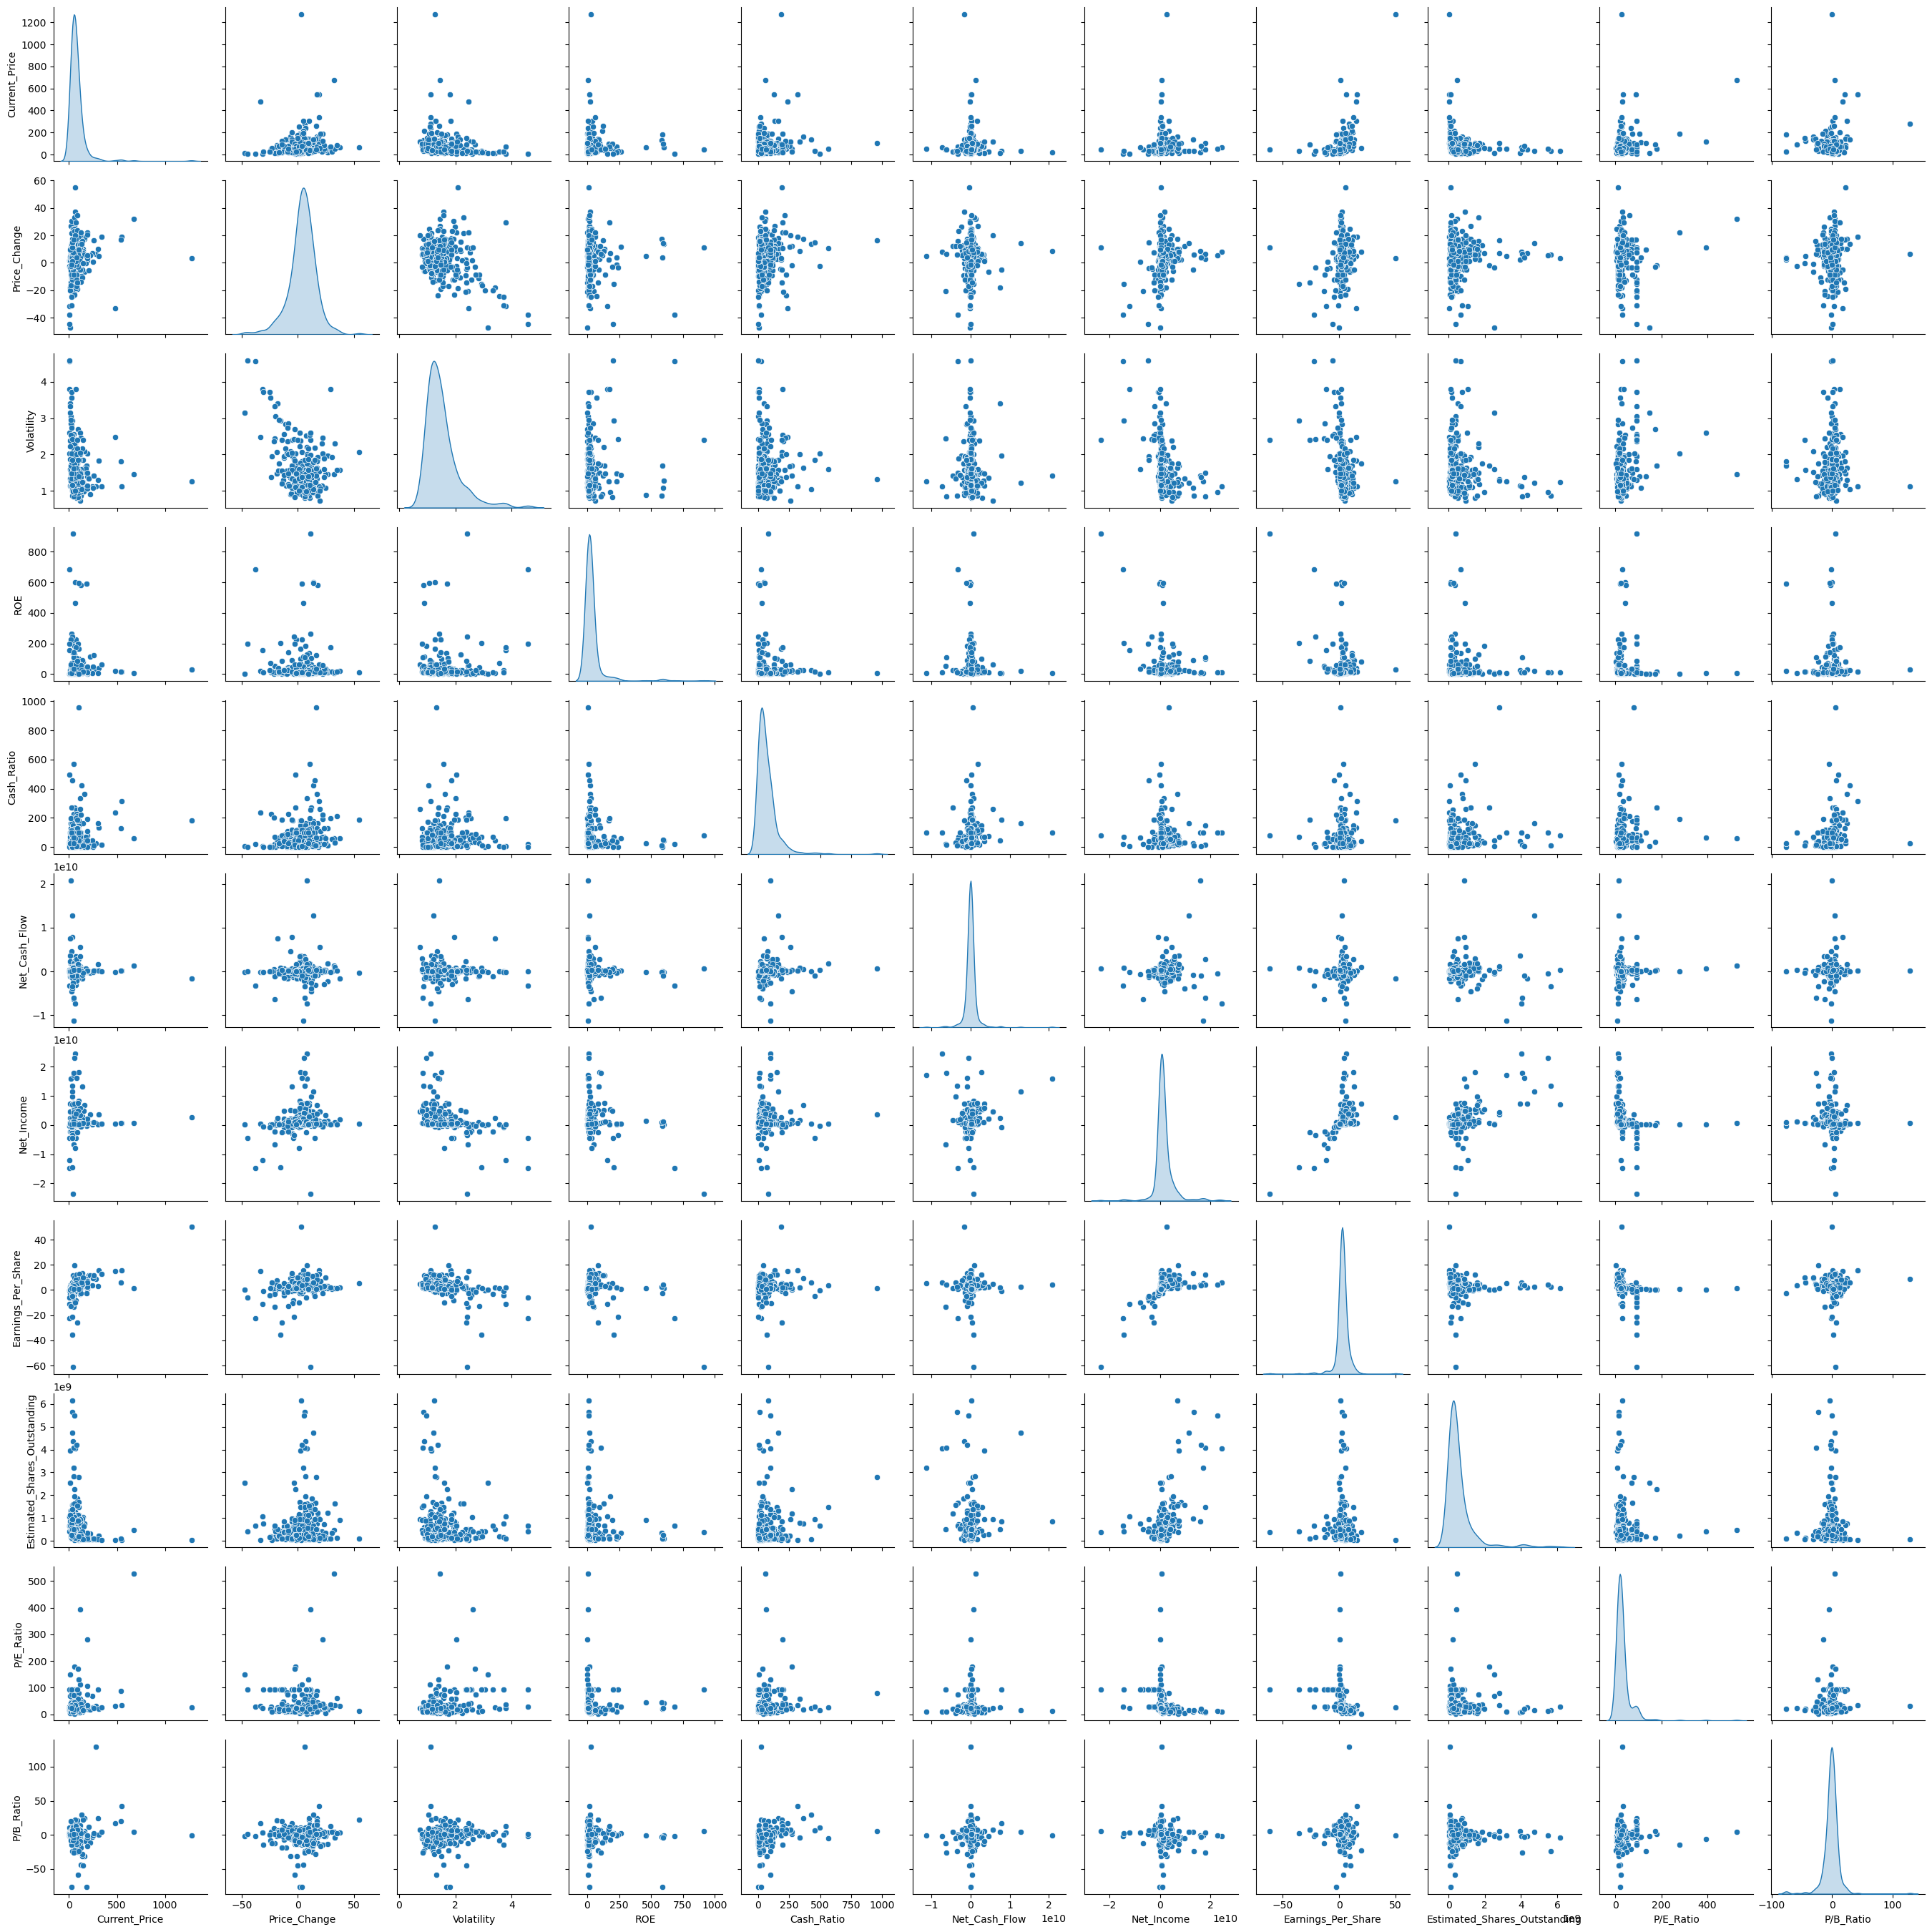

In [19]:
sns.pairplot(data=df[num_cols],diag_kind="kde")
plt.show()

## Data preprocessing

In [20]:
# Only numeric variables are to be used for clustering
num_cols

['Current_Price',
 'Price_Change',
 'Volatility',
 'ROE',
 'Cash_Ratio',
 'Net_Cash_Flow',
 'Net_Income',
 'Earnings_Per_Share',
 'Estimated_Shares_Outstanding',
 'P/E_Ratio',
 'P/B_Ratio']

In [21]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_cols].copy()
subset_scaled = scaler.fit_transform(subset)

In [22]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2652173220958
Number of Clusters: 4 	Average Distortion: 2.178151429073042
Number of Clusters: 5 	Average Distortion: 2.157168217284776
Number of Clusters: 6 	Average Distortion: 2.088579858195155
Number of Clusters: 7 	Average Distortion: 2.0156803260709855
Number of Clusters: 8 	Average Distortion: 1.9629758622878155
Number of Clusters: 9 	Average Distortion: 1.9166068238560794


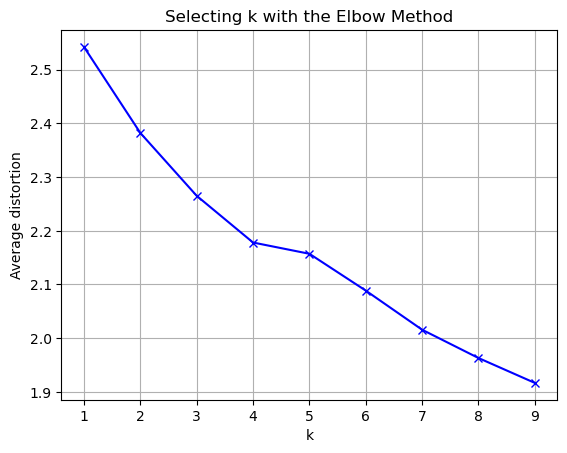

In [23]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.grid(True)
plt.show()

### Approximate value for K seems to be 3, 4, or 6.

### Let us check Silhouetted scores.

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.4644405674779403)
For n_clusters = 4, the silhouette score is 0.45434371948348606)
For n_clusters = 5, the silhouette score is 0.4153869737950477)
For n_clusters = 6, the silhouette score is 0.4118459845534201)
For n_clusters = 7, the silhouette score is 0.3980315597381588)
For n_clusters = 8, the silhouette score is 0.10512777196523385)
For n_clusters = 9, the silhouette score is 0.4199509372476413)


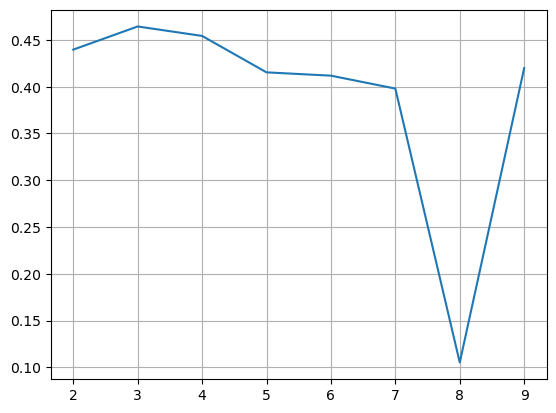

In [24]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.grid(True)
plt.show()

### From silhouette scores, 3 or 4 clusters seem to be indicated. Let us go with 4 clusters

### We will fit four clusters to our data

In [25]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=1)

In [26]:
# adding kmeans cluster labels to the original and scaled dataframes

df["Kmeans_clusters"] = kmeans.labels_
subset_scaled_df["Kmeans_clusters"] = kmeans.labels_

### Cluster profiling

In [27]:
cluster_profile = df.groupby("Kmeans_clusters").mean()

In [28]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("Kmeans_clusters")["Current_Price"].count().values
)

In [29]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightblue", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,count_in_each_segment
Kmeans_clusters,,,,,,,,,,,,
0,72.399112,5.066225,1.388319,34.620939,53.000000,-14046223.826715,1482212389.891697,3.621029,438533835.667184,23.843656,-3.358948,277
1,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,11
2,38.099260,-15.370329,2.910500,107.074074,50.037037,-159428481.481481,-3887457740.740741,-9.473704,480398572.845926,90.619220,1.342067,27
3,234.170932,13.400685,1.729989,25.600000,277.640000,1554926560.000000,1572611680.000000,6.045200,578316318.948800,74.960824,14.402452,25


In [30]:
# Membership in each cluster can be seen with code below:
for cl in df["Kmeans_clusters"].unique():
    print("In cluster {}, there are following stocks:".format(cl))
    print(df[df["Kmeans_clusters"] == cl]["Security"].unique())
    print()

In cluster 0, there are following stocks:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Archer-Daniels-Midland Co' 'Ameren Corp'
 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp' 'Allegion'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Ameriprise Financial' 'American Tower Corp A' 'AutoNation Inc'
 'Anthem Inc.' 'Aon plc' 'Amphenol Corp' 'Arconic Inc'
 'Activision Blizzard' 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Baxter International Inc.' 'BB&T Corporation' 'Bard (C.R.) Inc.'
 'The Bank of New York Mellon Corp.' 'Ball Corp' 'Bristol-Myers Squibb'
 'Boston Scientific' 'BorgWarner' 'Boston Properties' 'Caterpillar Inc.'
 'Chubb Limited' 'CBRE Group' 'Crown Castle Interna

<AxesSubplot:xlabel='Kmeans_clusters'>

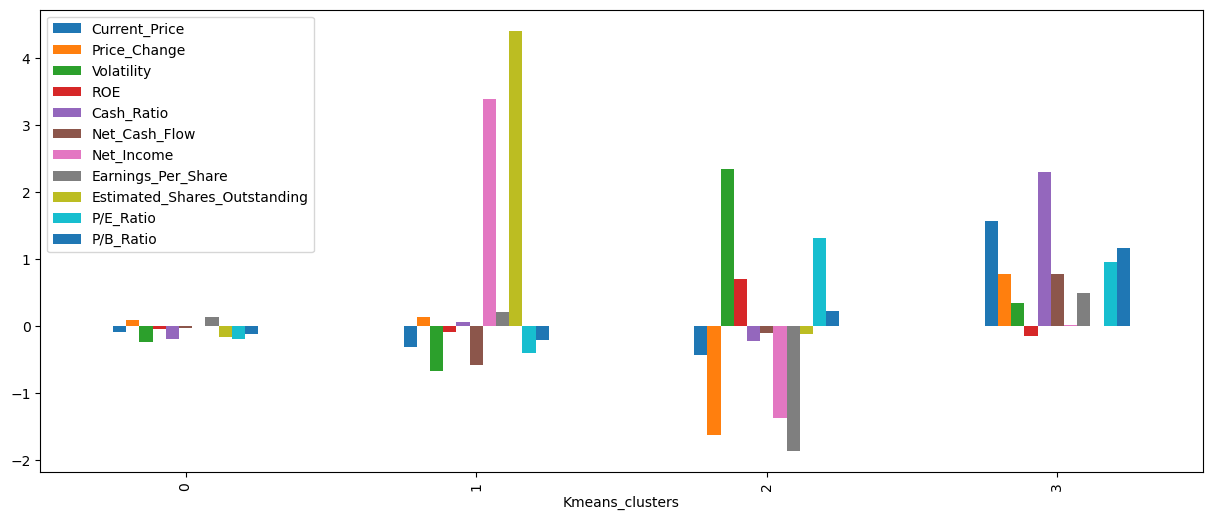

In [31]:
# plotting means in scaled data
subset_scaled_df.groupby("Kmeans_clusters").mean().plot.bar(figsize=(15, 6))

### The interpretation is difficult, particularly because the number of variables is high (11). Additionally, some of the variables, such as net income and earnings per share are highly correlated, which may degrade the clustering process. We can use the Principal Components Analysis to reduce dimensionality and multicollinearity.

## Principal Components Analysis

In [32]:
pca=PCA()
pca.fit(subset_scaled)

PCA()

In [33]:
np.set_printoptions(linewidth=200)
print(pca.components_)

[[-0.18335823 -0.27666842  0.42919618  0.30106508 -0.08417114 -0.03368814 -0.51091003 -0.5033668  -0.22120756  0.20815091 -0.00991673]
 [ 0.5774047   0.18815749  0.04101083 -0.06258117  0.32773726  0.1280034  -0.25155831  0.18433241 -0.36327549  0.37736302  0.360796  ]
 [-0.17770732  0.04646452  0.18283759  0.00473711  0.53919175  0.1855024   0.20918754 -0.27531285  0.58166569  0.24934832  0.2959799 ]
 [-0.00900284  0.65971773 -0.38664453  0.53431652  0.0838151  -0.13655589 -0.12101272 -0.26011429  0.02333621 -0.00303257 -0.14551133]
 [ 0.39287414 -0.12202474  0.14571667  0.12446023 -0.1588855  -0.56275703  0.17221048  0.06902206  0.32807051  0.47228787 -0.29493986]
 [ 0.04539895  0.07374983 -0.01301984 -0.04924358 -0.1433002   0.69439441  0.07660902 -0.02703535  0.00607268  0.39241333 -0.571456  ]
 [ 0.34597383 -0.32918961  0.06740711  0.69551664 -0.04384053  0.31995867  0.15598116  0.16995766  0.13220581 -0.30317218  0.12940702]
 [ 0.03785302 -0.10485332  0.17805858  0.00977663  0.69

In [34]:
print(pca.explained_variance_)

[2.51212401 1.58411327 1.33434149 1.11310406 1.09308721 0.95662194 0.82731447 0.71754029 0.4845015  0.2833637  0.12633645]


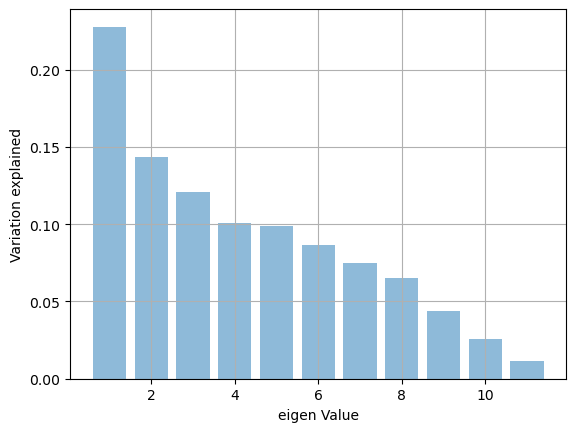

In [35]:
plt.bar(list(range(1,12)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.grid(True)
plt.show()

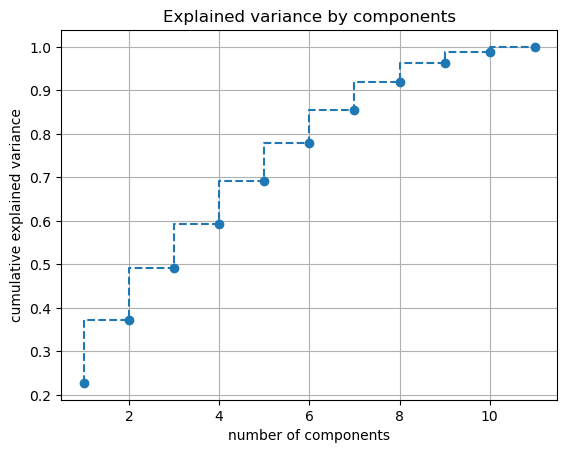

In [36]:
plt.step(list(range(1,12)),pca.explained_variance_ratio_.cumsum(), marker="o", linestyle = "--")
plt.title('Explained variance by components')
plt.xlabel('number of components')
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

Since we generally want to keep number of components that can explain at least 80% of variance, the above chart suggest that we keep six components

### Now we perform PCA with six principal components

In [37]:
pca1 = PCA(n_components=6, random_state=1)
pca1 = pca1.fit_transform(subset_scaled)

In [38]:
pca1

array([[-1.22829983, -0.9152819 , -0.31439615,  0.33091553,  0.40727503, -0.12134202],
       [-0.13290454, -1.02431235,  0.98801695,  0.2811608 ,  0.71660878,  0.18542352],
       [-1.07131193, -0.75199639,  0.79847105,  0.31444781, -0.27698645,  0.21805271],
       ...,
       [ 0.50544607,  0.82413076, -0.01812985,  0.49319991,  1.10098351,  1.89576066],
       [ 0.3532858 , -0.15269283, -0.01633773, -0.3354752 , -0.57666821, -0.29311642],
       [ 0.31587843,  0.47081787,  0.38346172,  0.65705891, -0.07537491,  0.32959708]])

In [39]:
df_pca1 = pd.DataFrame(data=pca1, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6'])

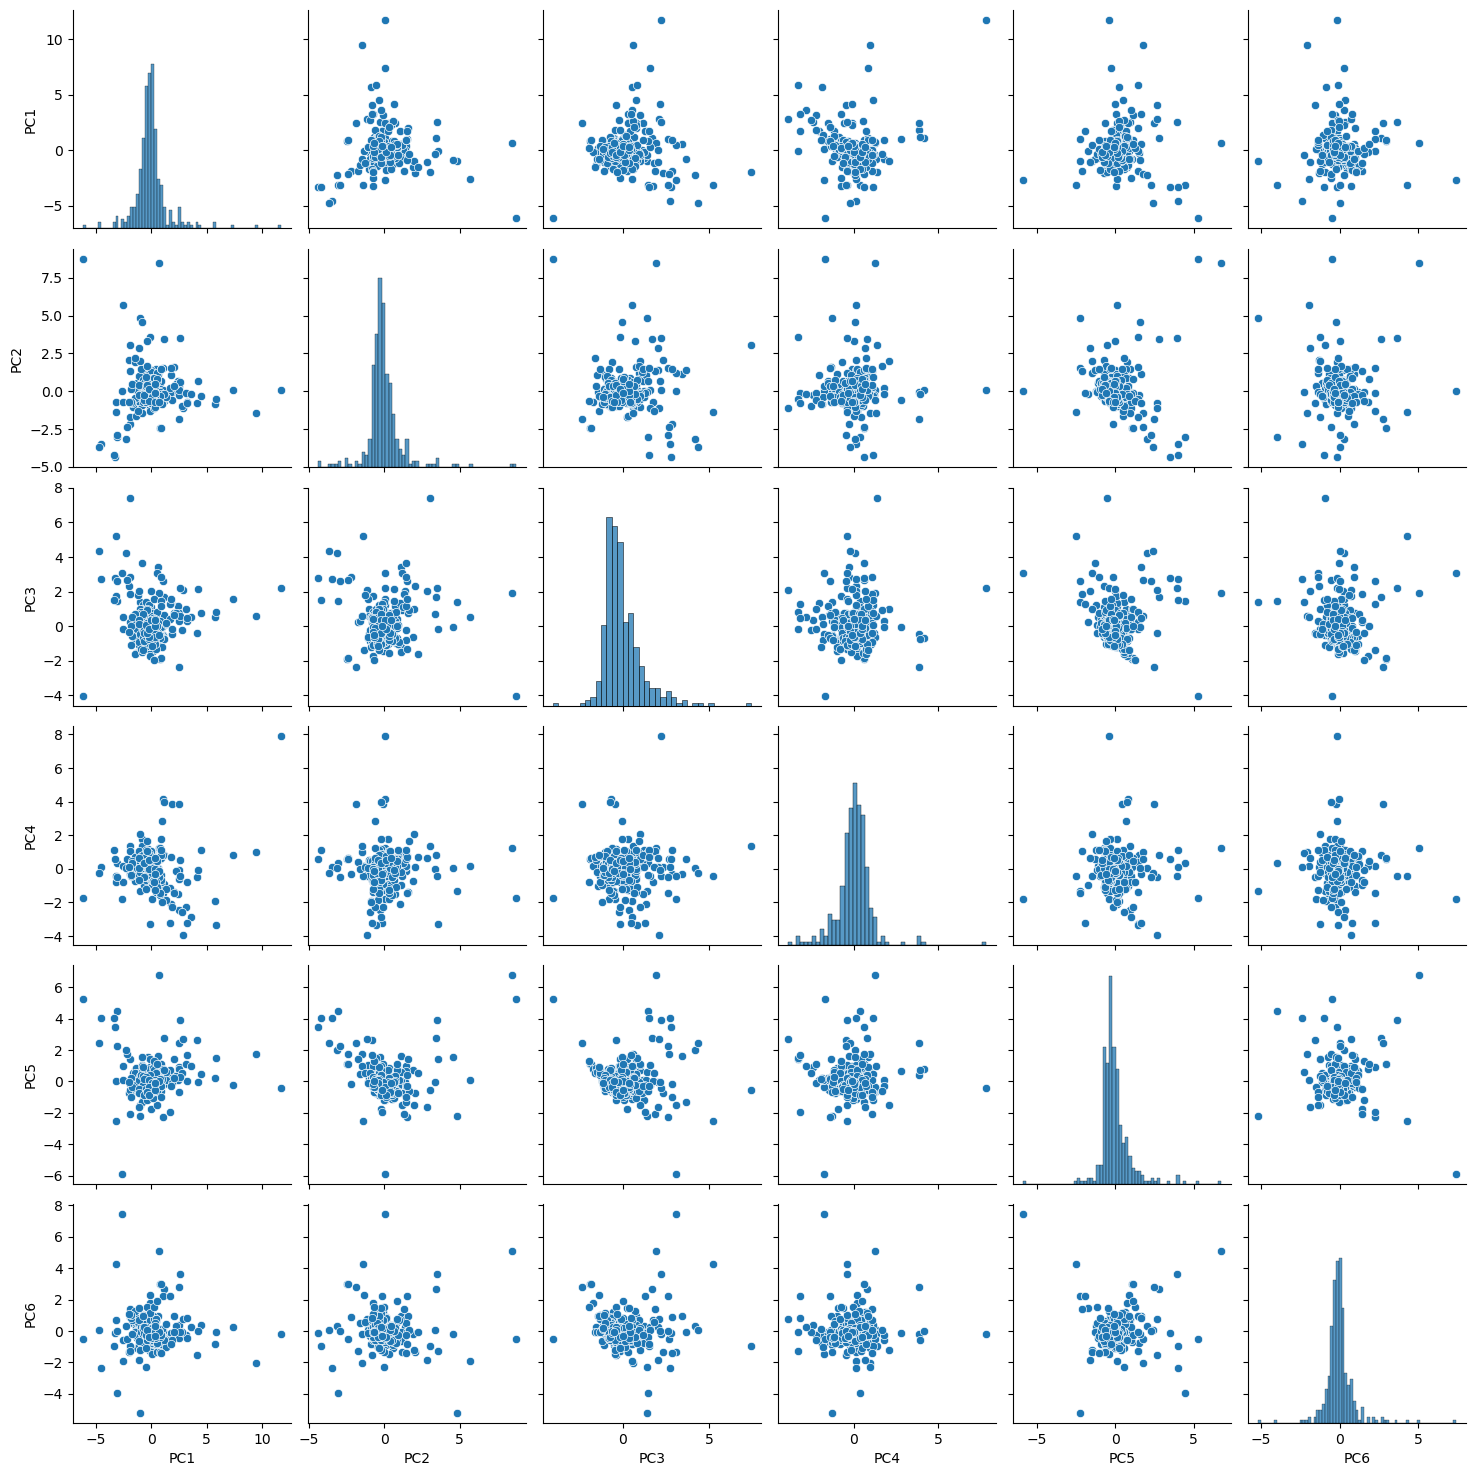

In [40]:
sns.pairplot(df_pca1)

### The pair plots show that the 6 Principal Components are Orthogonal

### Now we will carry out K-means clustering based on result of PCA

Number of Clusters: 1 	Average Distortion: 2.1614121443137986
Number of Clusters: 2 	Average Distortion: 1.9826835905696572
Number of Clusters: 3 	Average Distortion: 1.853300376177316
Number of Clusters: 4 	Average Distortion: 1.7616780891673853
Number of Clusters: 5 	Average Distortion: 1.714646260599083
Number of Clusters: 6 	Average Distortion: 1.6631912117781258
Number of Clusters: 7 	Average Distortion: 1.6186745849649693
Number of Clusters: 8 	Average Distortion: 1.5585984299430593
Number of Clusters: 9 	Average Distortion: 1.5321483009204417


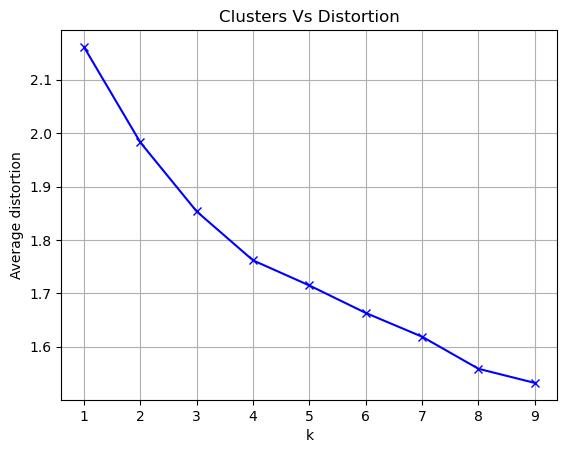

In [41]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_pca1)
    prediction = model.predict(df_pca1)
    distortion = (
        sum(
            np.min(cdist(pca1, model.cluster_centers_, "euclidean"), axis=1)
        )
        / df_pca1.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Clusters Vs Distortion")
plt.grid(True)
plt.show()

### Elbow method suggests 3 or 4 clusters. Let us check silhouette scores

For n_clusters = 2, the silhouette score is 0.4937161533372152)
For n_clusters = 3, the silhouette score is 0.5081260154355344)
For n_clusters = 4, the silhouette score is 0.5112054866890287)
For n_clusters = 5, the silhouette score is 0.48675937847234885)
For n_clusters = 6, the silhouette score is 0.4399320468232171)
For n_clusters = 7, the silhouette score is 0.4538224179664286)
For n_clusters = 8, the silhouette score is 0.14935012249198537)
For n_clusters = 9, the silhouette score is 0.15559087235342609)


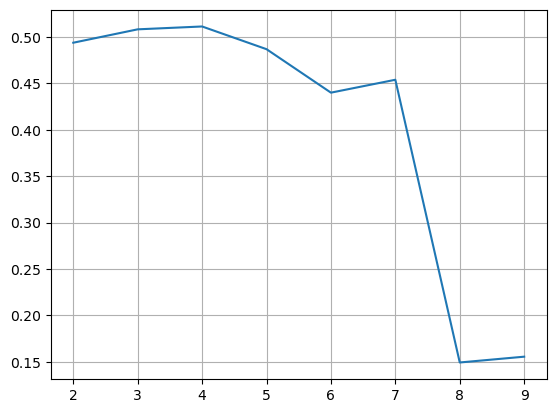

In [42]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_pca1))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_pca1, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.grid(True)
plt.show()

### Silhouette analysis also suggests 4 clusters

### Now we run K-means with 4 clusters

In [43]:
kmeans_pca1 = KMeans(n_clusters=4, init="k-means++",random_state=1)
kmeans_pca1.fit(df_pca1)

KMeans(n_clusters=4, random_state=1)

In [44]:
# we create a new dataframe with the original features and add the PCA scores and newly assigned clusters
df_pca_kmeans=pd.concat([df.reset_index(drop=True),pd.DataFrame(df_pca1)],axis=1)
df_pca_kmeans.columns.values[-6:]=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"]
# The last column we add contians the pca1 k-means clustering labels
df_pca_kmeans["Kmeans_clusters_PCA"] = kmeans_pca1.labels_

In [45]:
df_pca_kmeans

,Security,GICS_Sector,GICS_Sub_Industry,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,Kmeans_clusters,PC1,PC2,PC3,PC4,PC5,PC6,Kmeans_clusters_PCA
0,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219,0,-1.228300,-0.915282,-0.314396,0.330916,0.407275,-0.121342,0
1,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068,0,-0.132905,-1.024312,0.988017,0.281161,0.716609,0.185424,0
2,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171,0,-1.071312,-0.751996,0.798471,0.314448,-0.276986,0.218053,0
3,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651,0,-0.126537,1.176945,0.915497,0.626794,0.001351,-0.076122,0
4,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810,3,0.576854,1.113511,3.399115,-0.280629,1.622087,0.918350,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,Yahoo Inc.,Information Technology,Internet Software & Services,33.259998,14.887727,1.845149,15,459,-1032187000,-4359082000,-4.64,9.394573e+08,28.976191,6.261775,3,0.860894,1.453357,2.842609,1.091880,-1.024426,-1.396135,2
336,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,4.353535e+08,17.682214,-3.838260,0,0.651640,-0.689641,-0.500099,-0.131556,0.006434,-0.088933,0
337,Zimmer Biomet Holdings,Health Care,Health Care Equipment,102.589996,9.347683,1.404206,1,100,376000000,147000000,0.78,1.884615e+08,131.525636,-23.884449,0,0.505446,0.824131,-0.018130,0.493200,1.100984,1.895761,0
338,Zions Bancorp,Financials,Regional Banks,27.299999,-1.158588,1.468176,4,99,-43623000,309471000,1.20,2.578925e+08,22.749999,-0.063096,0,0.353286,-0.152693,-0.016338,-0.335475,-0.576668,-0.293116,0


### A visual inspection of cluster assignments reveals that cluster assignments after PCA-based clustering are mostly similar to cluster assignments done earlier. However, there are some differences too. We hope that cluster assignments after PCA are more logical and represent the data better.

### Let us create a 2-d visualization of the segments by using the first two components.

<function matplotlib.pyplot.show(close=None, block=None)>

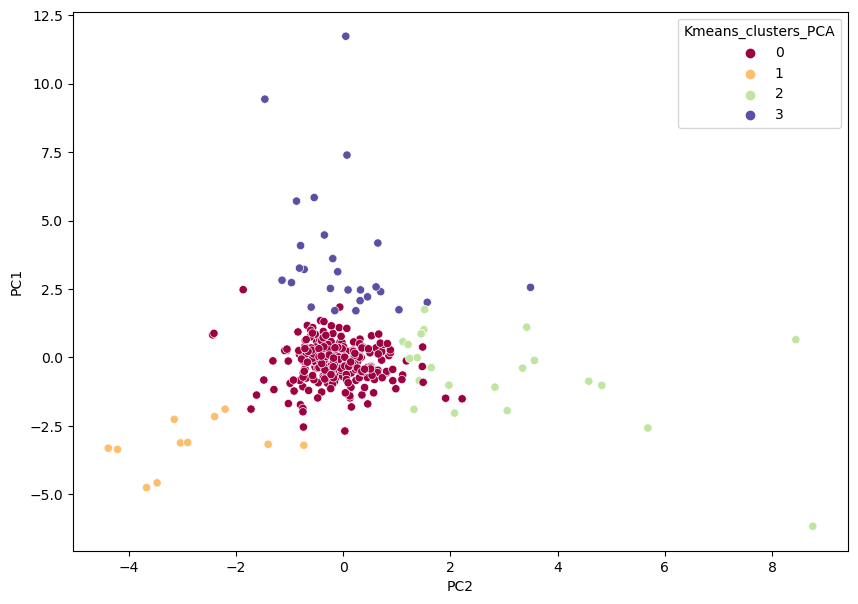

In [46]:
# Plot data by components: The Y axis is the first component, X axis is the second
x_axis=df_pca_kmeans["PC2"]
y_axis=df_pca_kmeans["PC1"]
plt.figure(figsize=(10,7))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_pca_kmeans["Kmeans_clusters_PCA"],palette=("Spectral"))
plt.show

### We can now clearly see four clusters, although we used only two of the six Principal Components. This validates that these four clusters is a good representation of the data.

### We will now create final cluster profiles

In [47]:
cluster_profile_final = df_pca_kmeans.groupby("Kmeans_clusters_PCA").mean()

In [48]:
cluster_profile_final["count_in_each_segment"] = (
    df_pca_kmeans.groupby("Kmeans_clusters_PCA")["Current_Price"].count().values
)

In [49]:
# let's display cluster profiles
cluster_profile_final.style.highlight_max(color="lightgreen", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,Kmeans_clusters,PC1,PC2,PC3,PC4,PC5,PC6,count_in_each_segment
Kmeans_clusters_PCA,,,,,,,,,,,,,,,,,,,
0,73.038473,5.077788,1.389996,34.530466,53.451613,61011096.774194,1541246709.677419,3.665179,439245756.915090,23.790739,-3.337649,0.021505,-0.185953,-0.132299,-0.336317,0.077966,-0.156046,0.020815,279
1,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,1.000000,-3.175555,-2.867718,2.920501,0.059906,1.982893,-0.163906,11
2,240.482317,13.985149,1.739349,25.913043,291.695652,780881043.478261,864360521.739130,5.720435,581835403.226957,80.047699,15.688552,3.000000,-0.568655,2.948162,1.690190,0.188092,0.117439,-0.272661,23
3,38.099260,-15.370329,2.910500,107.074074,50.037037,-159428481.481481,-3887457740.740741,-9.473704,480398572.845926,90.619220,1.342067,2.000000,3.699669,0.024021,0.845647,-0.990278,0.704588,0.083957,27


### Interpretation:
    1.Cluster 0: There are 279 stocks in this segment. They are low-priced shares with low P/E ratio and low market capitalization
    2.Cluster 1: There are only 11 stocks in this cluster. They are big companies with large profits but currently have negative cash flow and low P/E
    3.Cluster 2: There are 23 stocks in this cluster. They have high price and have grown the maximum in price. They have good cash flow and high EPS. they are being traded at a relatively higher P/E ratio.
    4.Cluster 3: There are 27 stocks in this segment. They are highly volatile and have the maximum Return on Equity. They are making losses and have a negative cash flow. they have the highest P/E ratio

In [50]:
# Looking at 11 stocks in cluster 1
df_pca_kmeans.loc[df_pca_kmeans["Kmeans_clusters_PCA"]==1]

,Security,GICS_Sector,GICS_Sub_Industry,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,Kmeans_clusters,PC1,PC2,PC3,PC4,PC5,PC6,Kmeans_clusters_PCA
52,Citigroup Inc.,Financials,Banks,51.750000,4.714695,1.261984,8,99,-11208000000,17242000000,5.41,3.187061e+09,9.565619,-1.167533,1,-3.121139,-3.034015,1.476523,0.333070,4.454569,-3.970187,1
123,Ford Motor,Consumer Discretionary,Automobile Manufacturers,14.090000,2.398256,1.151454,26,43,3515000000,7373000000,1.86,3.963978e+09,7.575269,5.108756,1,-1.888290,-2.202620,2.854323,-0.305275,-0.163013,0.893808,1
140,Gilead Sciences,Health Care,Biotechnology,101.190002,2.689264,1.494060,98,148,2824000000,18108000000,12.37,1.463864e+09,8.180275,3.159446,1,-3.209591,-0.733548,1.739150,-0.770922,0.032982,0.711215,1
167,Intel Corp.,Information Technology,Semiconductors,34.450001,14.035095,1.226022,19,162,12747000000,11420000000,2.41,4.738589e+09,14.294606,3.954975,1,-3.171728,-1.399307,5.215994,-0.405820,-2.493166,4.275334,1
177,JPMorgan Chase & Co.,Financials,Banks,66.029999,8.033377,1.130337,10,99,-7341000000,24442000000,6.05,4.040000e+09,10.914049,-1.886881,1,-4.581366,-3.469868,2.727694,0.124109,4.011255,-2.374506,1
181,Coca Cola Company,Consumer Staples,Soft Drinks,42.959999,6.812526,0.889913,29,74,-1649000000,7351000000,1.69,4.349704e+09,25.420118,-1.466307,1,-2.160810,-2.398067,2.663022,0.599786,1.764456,-0.525081,1
246,Pfizer Inc.,Health Care,Pharmaceuticals,32.279999,3.130991,1.238748,11,79,298000000,6960000000,1.13,6.159292e+09,28.566371,-4.213309,1,-2.260683,-3.149826,4.199180,0.050627,2.020844,0.284675,1
287,AT&T Inc,Telecommunications Services,Integrated Telecommunications Services,34.410000,5.942118,0.859442,11,11,-3482000000,13345000000,2.37,5.630802e+09,14.518987,-23.537323,1,-3.314033,-4.381077,2.756390,0.598329,3.467497,-0.148560,1
317,Verizon Communications,Telecommunications Services,Integrated Telecommunications Services,46.220001,6.277303,0.842592,109,14,-6128000000,17879000000,4.38,4.081963e+09,10.552512,-26.380687,1,-3.360570,-4.209096,1.508825,1.126775,4.030491,-0.990614,1
320,Wells Fargo,Financials,Banks,54.360001,5.532912,0.969774,12,99,-460000000,22894000000,4.18,5.477033e+09,13.004785,-0.938007,1,-4.754552,-3.666322,4.363908,-0.228532,2.433456,0.033255,1


## Actionable Insights and Recommendations

### Stocks in cluster 2 are high-growth, high value stocks. Although they are being traded at higher than average P/E, their performance and growth potential makes them good candidates for investment. However, their volatility being somewhat high, they can be bought at the next drop in their price level. Some well known companies in this cluster are Amazon, TripAdvisor, and First Solar Inc.

### Stocks in cluster 1 are very big companies with highest profits. However, due to negative clash flow they are being traded at low P/E. Given the decent ROE and EPS, these stocks currently present the best opportunity for investment. Some companies in this group are Intel Corp., Pfizer and Verizon Communications. However, companies with negative P/B ratio should be avoided.

### Stocks in cluster 3 are very volatile. though they have given good return on equity, there are currently making losses. They are also being traded at very high P/E ratios. Most of he stocks in this cluster are in Energy sector. Investment in these stocks is not recommended at this stage. Government policies in this industrial sector should be watched before considering any investment

### Stocks in cluster 0 represent the majority of the companies in this data set. These companies are, "somewhere in the middle". Investment in these stocks can be considered after further analysis of that company's financials. Some good candidates in this cluster seem to be Abbott labs, UPS, and Yum Brands inc.